## Stroke Prediction Using Machine Learning Models

## Importing neccesary library

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=FutureWarning)

# Suppress only ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

## Importing the dataset

In [5]:
df=pd.read_csv(r'C:\Users\Administrator\Downloads\Documents\stroke-data.csv')
df.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


## About the data
The dataset contains 5110 entries and 12 columns with a mix of categorical and numerical data. Key features include age, hypertension, heart_disease, avg_glucose_level, and bmi. The target variable is stroke (binary: 1 = Stroke, 0 = No Stroke).

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


## Objectives
The objective of this project is to develop a predictive model for stroke occurrences based on health and demographic factors such as age, BMI, and smoking status. The dataset was processed, and several machine learning models were applied to compare their predictive performance.

## Data Preprocessing
* Missing Values: Missing BMI values were imputed using the median.
* Encoding: Categorical variables were transformed using one-hot encoding.
* Scaling: Numerical features were standardized using StandardScaler.
* Class Imbalance: The dataset was highly imbalanced. To address this, SMOTE (Synthetic Minority Over-sampling  Technique) and random undersampling were used to balance the classes.
* The dataset was split into training and test sets with a 70/30 ratio

In [7]:
median_bmi = df['bmi'].median()
df['bmi'].fillna(median_bmi, inplace=True)

In [8]:
df= df.drop(['id'], axis=1)

In [9]:
class_distribution = df['stroke'].value_counts()
print(class_distribution) 

0    4861
1     249
Name: stroke, dtype: int64


In [10]:
X = df.drop(['stroke'], axis=1)
y = df['stroke']

In [11]:
y

0       1
1       1
2       1
3       1
4       1
       ..
5105    0
5106    0
5107    0
5108    0
5109    0
Name: stroke, Length: 5110, dtype: int64

In [12]:
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


In [13]:
numerical_transformer = SimpleImputer(strategy='median')
X[numerical_cols] = numerical_transformer.fit_transform(X[numerical_cols])

In [14]:
categorical_transformer = OneHotEncoder(handle_unknown='ignore', sparse=False)
X_encoded = categorical_transformer.fit_transform(X[categorical_cols])

In [15]:
encoded_feature_names = categorical_transformer.get_feature_names_out(categorical_cols)


In [16]:
X_preprocessed = np.hstack([X[numerical_cols], X_encoded])

In [17]:
X = pd.concat([X[numerical_cols], pd.DataFrame(X_encoded)], axis=1)

In [18]:
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=np.concatenate([numerical_cols, encoded_feature_names]))

In [19]:
X_preprocessed_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   hypertension                    5110 non-null   float64
 2   heart_disease                   5110 non-null   float64
 3   avg_glucose_level               5110 non-null   float64
 4   bmi                             5110 non-null   float64
 5   gender_Female                   5110 non-null   float64
 6   gender_Male                     5110 non-null   float64
 7   gender_Other                    5110 non-null   float64
 8   ever_married_No                 5110 non-null   float64
 9   ever_married_Yes                5110 non-null   float64
 10  work_type_Govt_job              5110 non-null   float64
 11  work_type_Never_worked          5110 non-null   float64
 12  work_type_Private               51

In [20]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_preprocessed_df)


In [21]:
smote = SMOTE()
X_smote, y_smote = smote.fit_resample(X_preprocessed_df, y)

In [22]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_smote, y_smote)

In [23]:
class_weight = 'balanced'

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

## Model Training

## Classifier Models and Hyperparameter Tuning
The following models were trained, and hyperparameter tuning was done using GridSearchCV:

* Naive Bayes
* Logistic Regression
* K-Nearest Neighbors (KNN)
* Logistic Regression
* Random Forest
* Support Vector Machine (SVM)


* Stacking Classifier (combining KNN, Random Forest, and Logistic Regression)

In [25]:
def cross_validate_and_tune(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    print(f'Best Parameters: {grid_search.best_params_}')
    return grid_search.best_estimator_

In [26]:
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

GaussianNB()

In [27]:
y_pred_nb = nb_model.predict(X_test)
print("\nNaive Bayes Classification Report:\n", classification_report(y_test, y_pred_nb))


Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.39      0.55      1486
           1       0.61      0.97      0.75      1431

    accuracy                           0.68      2917
   macro avg       0.77      0.68      0.65      2917
weighted avg       0.77      0.68      0.65      2917



In [28]:
knn_model = KNeighborsClassifier()
param_grid_knn = {'n_neighbors': [3, 5, 7, 9, 11, 13, 15]}
best_knn = cross_validate_and_tune(knn_model, param_grid_knn, X_train, y_train)

Best Parameters: {'n_neighbors': 3}


In [29]:
log_reg = LogisticRegression(max_iter=1000,class_weight=class_weight)
param_grid_log_reg = {'C': [0.01, 0.1, 1, 10, 100]}


best_log_reg = cross_validate_and_tune(log_reg, param_grid_log_reg, X_train, y_train)

Best Parameters: {'C': 0.1}


In [30]:
rf_model = RandomForestClassifier(class_weight=class_weight)
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [10, 20, None]}
best_rf = cross_validate_and_tune(rf_model, param_grid_rf, X_train, y_train)

Best Parameters: {'max_depth': 20, 'n_estimators': 100}


In [31]:
svm_model = SVC(probability=True, max_iter=5000, tol=1e-6, class_weight=class_weight)
param_grid_svm = {'C': [0.01, 0.1, 1, 10], 'kernel': ['linear', 'rbf']}
best_svm = cross_validate_and_tune(svm_model, param_grid_svm, X_train, y_train)

Best Parameters: {'C': 10, 'kernel': 'rbf'}


In [32]:
base_models = [
    ('knn', KNeighborsClassifier(n_neighbors=5)),
    ('rf', RandomForestClassifier(n_estimators=100, class_weight='balanced'))
]

In [33]:
meta_model = LogisticRegression()

In [34]:
stacking_clf = StackingClassifier(estimators=base_models, final_estimator=meta_model)

In [35]:
param_grid_stacking = {
    'final_estimator__C': [0.01, 0.1, 1, 10],  
    'rf__n_estimators': [50, 100],  
    'knn__n_neighbors': [3, 5, 7],  
}

In [36]:
grid_search_stacking = GridSearchCV(stacking_clf, param_grid_stacking, cv=5, scoring='accuracy')
best_stacking = grid_search_stacking.fit(X_train, y_train)

## Confusion matrix visualization

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [38]:
def plot_confusion_matrix(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()
    plt.title(f'Confusion Matrix - {title}')
    plt.show()

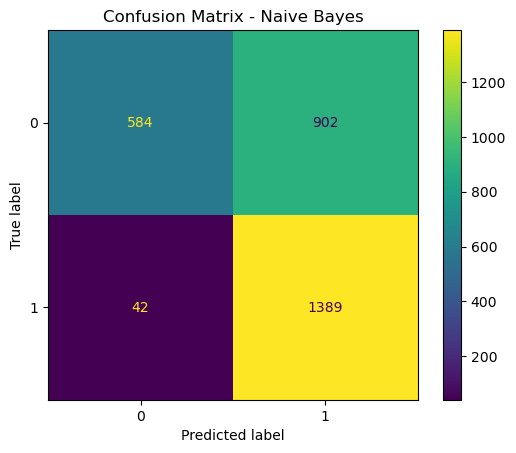

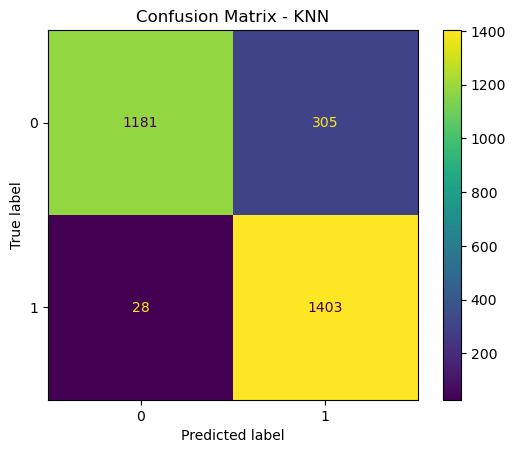

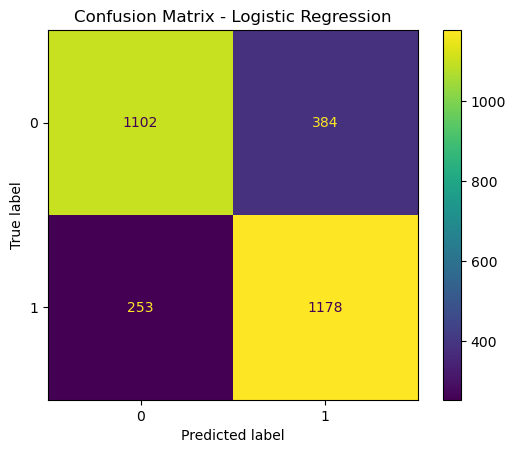

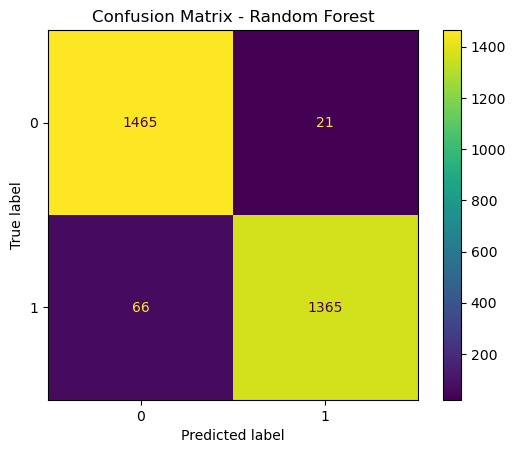

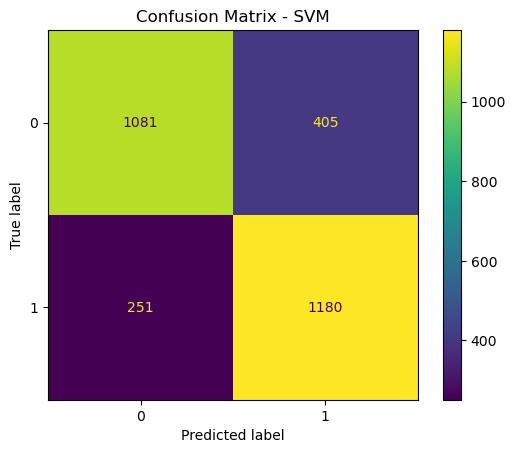

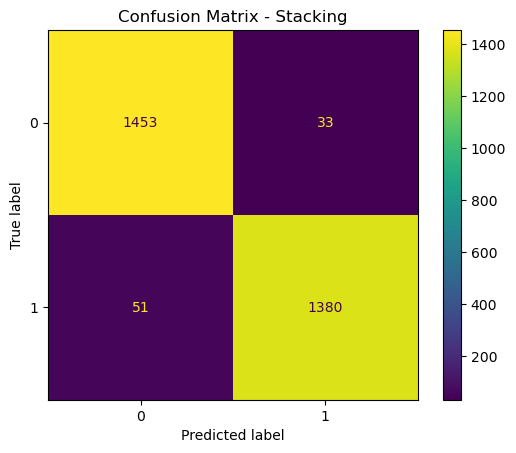

In [39]:
plot_confusion_matrix(nb_model, X_test, y_test, "Naive Bayes")
plot_confusion_matrix(best_knn, X_test, y_test, "KNN")
plot_confusion_matrix(best_log_reg, X_test, y_test, "Logistic Regression")
plot_confusion_matrix(best_rf, X_test, y_test, "Random Forest")
plot_confusion_matrix(best_svm, X_test, y_test, "SVM")
plot_confusion_matrix(best_stacking, X_test, y_test, "Stacking")


# Model Evaluation
Models were evaluated on accuracy, precision, recall, and F1-score.

In [40]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    return acc, precision, recall, f1

In [41]:
best_knn_metrics =evaluate_model(best_knn, X_test, y_test)
log_reg_metrics = evaluate_model(best_log_reg, X_test, y_test)
rf_metrics = evaluate_model(best_rf, X_test, y_test)
svm_metrics = evaluate_model(best_svm, X_test, y_test)
stacking_metrics = evaluate_model(best_stacking, X_test, y_test)

In [42]:
metrics_dict = {
    'KNN': best_knn_metrics,
    'Logistic Regression': log_reg_metrics,
    'Random Forest': rf_metrics,
    'SVM': svm_metrics,
    'Stacking': stacking_metrics
    
}


metrics_df = pd.DataFrame(metrics_dict, index=['Accuracy', 'Precision', 'Recall', 'F1-Score'])


metrics_df_transposed = metrics_df.T
metrics_df_transposed

,Accuracy,Precision,Recall,F1-Score
KNN,0.885842,0.821429,0.980433,0.893915
Logistic Regression,0.781625,0.754161,0.823201,0.787170
Random Forest,0.970175,0.984848,0.953878,0.969116
SVM,0.775111,0.744479,0.824598,0.782493
Stacking,0.971203,0.976645,0.964361,0.970464


# Model Recommendation
* Random Forest is the top performer with an accuracy of 97.02% and an F1-score of 0.969, making it ideal for high-precision requirements.
* Stacking performs comparably, with an accuracy of 97.12% and an F1-score of 0.970, offering robust generalization through ensemble learning.
* KNN also shows strong performance, especially in recall (0.980), making it suitable for cases where minimizing false negatives is critical.

# Key Insight
* Random Forest and Stacking consistently outperform other models, with high precision and recall, indicating their strong predictive power.
* KNN excels in recall, detecting more true positives but with slightly lower precision.
* SVM and Logistic Regression perform respectably but are less accurate, making them less suitable for high-stakes predictions.

In [43]:
def plot_feature_importance(model, X, title):
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        feature_names = X.columns
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(10, 6))
        plt.title(f'Feature Importances - {title}')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
        plt.xlim([-1, X.shape[1]])
        plt.show()
    else:
        print(f'{title} does not support feature importance.')

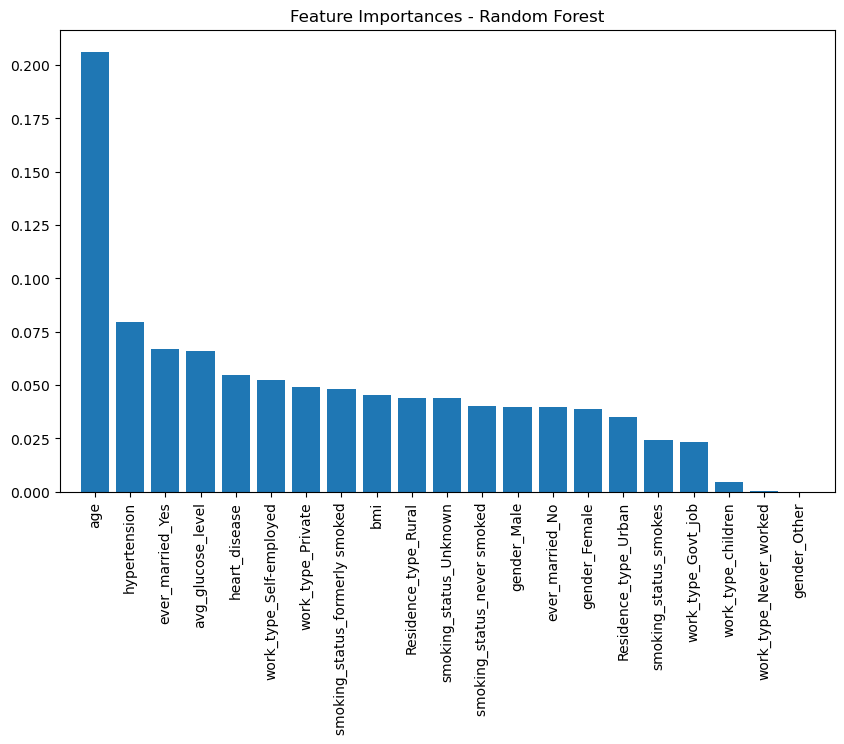

In [44]:
plot_feature_importance(best_rf, pd.DataFrame(X_scaled, columns=X_preprocessed_df.columns), 'Random Forest')


# Feature Importance

Random Forest: Identified important features like age, hypertension,ever_married, avg_glucose_level, and heart_disease.

# Future Recommendations

* Data Collection: Acquiring more data could enhance the model's generalizability and potentially improve the performance of more complex models like SVM and Stacking.
* Feature Engineering: Incorporating additional features such as physical activity, dietary habits, and family medical history could provide better context for stroke prediction.

# Conclusion
Based on model performance, Random Forest and Stacking are the best choices for this task, offering a balance between precision and recall. Future improvements could involve further hyperparameter tuning or exploring more complex ensemble methods to boost accuracy.